# Preprocessing and visualization of Dataset #1: Adults

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

In [8]:
# 1. Load the datasets into Pandas dataframes
names1=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'over-50K']
dataset1_train = pd.read_csv('adult_train.csv', index_col=False, names=names1, sep=',\s', na_values=['?'], engine='python')
dataset1_test = pd.read_csv('adult_test.csv', index_col=False, names=names1, sep=',\s', na_values=['?', 'nan', '|1x3 Cross validator'], engine='python')

print(dataset1_train.shape)

(32561, 15)


## Clean and visualize data

(30162, 15)
count             30162
unique               41
top       United-States
freq              27504
Name: native-country, dtype: object
                     age    fnlwgt  education-num       sex  capital-gain  \
age             1.000000 -0.076511       0.043526  0.081993      0.080154   
fnlwgt         -0.076511  1.000000      -0.044992  0.025362      0.000422   
education-num   0.043526 -0.044992       1.000000  0.006157      0.124416   
sex             0.081993  0.025362       0.006157  1.000000      0.048814   
capital-gain    0.080154  0.000422       0.124416  0.048814      1.000000   
capital-loss    0.060165 -0.009750       0.079646  0.047011     -0.032229   
hours-per-week  0.101599 -0.022886       0.152522  0.231268      0.080432   
native-country  0.016259 -0.083390       0.127207 -0.003006      0.012375   
over-50K        0.241998 -0.008957       0.335286  0.216699      0.221196   

                capital-loss  hours-per-week  native-country  over-50K  
age         

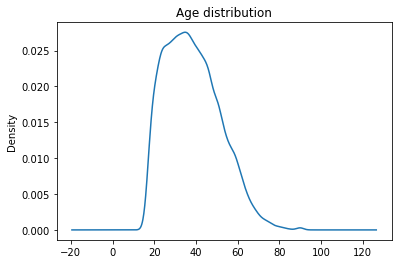

(30162, 13)
(30162, 12)


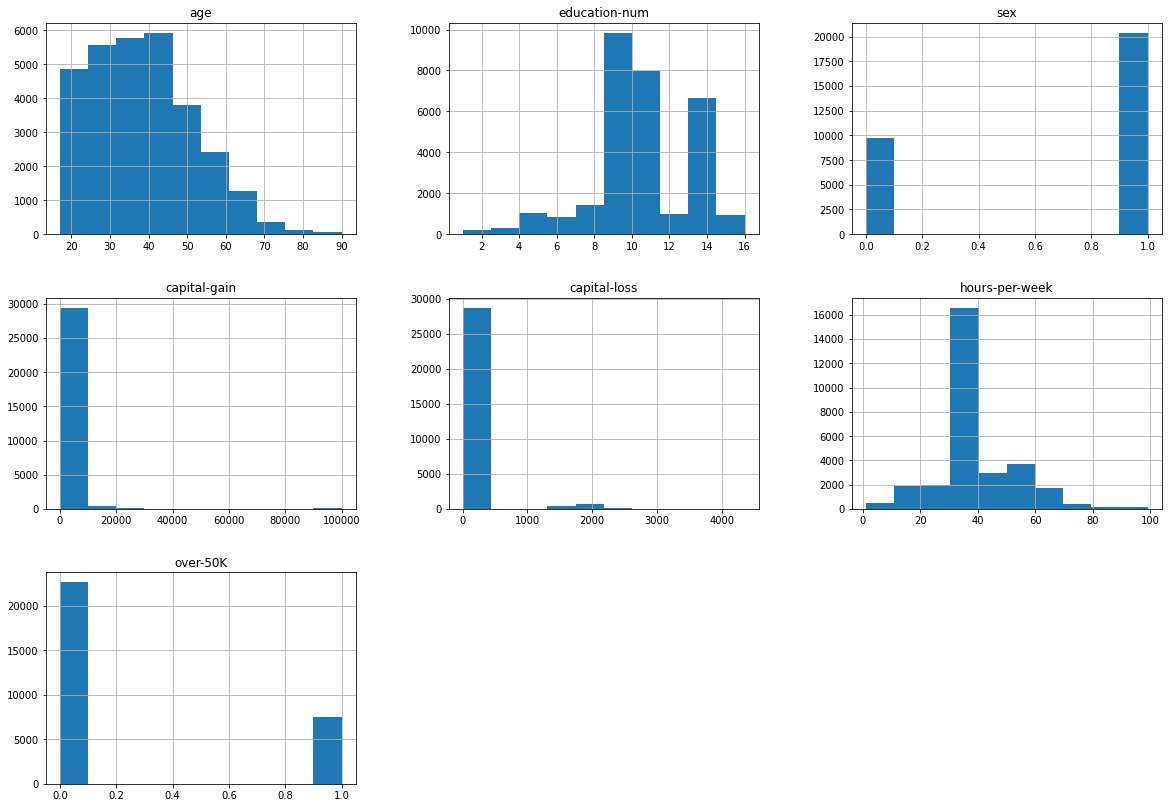

In [9]:
# Remove instances with missing/invalid data entries
dataset1_train.dropna(axis=0, how='any', inplace=True)
dataset1_test.dropna(axis=0, how='any', inplace=True)
print(dataset1_train.shape)

# Encode Over 50K as 1
dataset1_train['over-50K'] = dataset1_train['over-50K'].map({'>50K': 1, '<=50K': 0})
dataset1_test['over-50K'] = dataset1_test['over-50K'].map({'>50K': 1, '<=50K': 0})

# Encode Male as 1
dataset1_train['sex'] = dataset1_train['sex'].map({'Male': 1, 'Female': 0})
dataset1_test['sex'] = dataset1_test['sex'].map({'Male': 1, 'Female': 0})

print(dataset1_train['native-country'].describe()) 
# Since 91% of native-country data is US, we will categorize this column as "US" and "non-US".

# Encode US as 1 and non-US as 0
dataset1_train['native-country'] = np.where(dataset1_train['native-country']=='United-States', 1, 0)
dataset1_test['native-country'] = np.where(dataset1_test['native-country']=='United-States', 1, 0)

# Correlation
correlations = dataset1_train.corr(method="pearson")
print(correlations)

# From the above correlations, we can interpret that 'fnlgwt' and 'native-country' are not relevant to predicting the salary as their correlation is below 0.09.

# Remove uncorrelated columns
dataset1_train = dataset1_train.drop(columns=['fnlwgt', 'native-country'])
dataset1_test = dataset1_test.drop(columns=['fnlwgt', 'native-country'])

# Visualize age distribution
dataset1_train.age.plot(kind='kde')
plt.title('Age distribution')
plt.show()

# Visualize all numerical categories
dataset1_train.hist(figsize=(20, 14))

# Visualize categorical data
dataset1_train['education'].value_counts()
pd.crosstab(dataset1_train['education-num'], columns=dataset1_train['education'])
print(dataset1_train.shape)

# Remove education-num as it gives no more information than education
dataset1_train = dataset1_train.drop(columns='education-num')
dataset1_test = dataset1_test.drop(columns='education-num')
print(dataset1_train.shape)

## One-hot encoding

In [10]:
import category_encoders as ce

# Convert discrete variables into multiple variables using one-hot encoding
# Discrete columns: workclass, education, marital-status, occupation, relationship, sex, native-country
encoder = ce.OneHotEncoder(cols=['workclass', 'education', 'marital-status', 'occupation', 'race', 'relationship'], use_cat_names=True)
train_encoded_1 = encoder.fit_transform(dataset1_train)
test_encoded_1 = encoder.transform(dataset1_test) 

names_1_encoded = train_encoded_1.columns

/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [11]:
# Normalize
from sklearn import preprocessing

# Normalize training set
x = train_encoded_1.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_1 = pd.DataFrame(x_scaled, columns=names_1_encoded)

# Normalize test set
x = test_encoded_1.values
x_scaled = min_max_scaler.fit_transform(x)
normalized_dataset_1_test = pd.DataFrame(x_scaled, columns=names_1_encoded)

/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:400: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:401: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


# Experiments


## Cross Validation function

In [12]:
# Note: Inspired from cross validation code given in class

def cross_validate(total, folds=5):
    n = total // folds # Number of instances per split
    inds = [] # Initiate indexes
    for i in range(folds):
        tr_inds = [] # Training set index
        val_inds = list(range(i * n, (i+1)*n)) # Validation set index
        if i > 0:
            tr_inds = list(range(i*n))
        if i < folds - 1:
            tr_inds = tr_inds + list(range((i+1)*n, total))
        yield tr_inds, val_inds

## KNN

In [13]:
# Split the data
x, y = train_encoded_1.iloc[:,:-1].to_numpy(), train_encoded_1['over-50K'].to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, shuffle=True)

# Split further for testing purposes (growing samples)
data_75 = train_encoded_1.sample(frac=0.30)
x_75, y_75 = data_75.iloc[:,:-1].to_numpy(), data_75['over-50K'].to_numpy()
x_train_75, x_test_75, y_train_75, y_test_75 = train_test_split(x_75, y_75, test_size=0.15, shuffle=True)

data_50 = train_encoded_1.sample(frac=0.20)
x_50, y_50 = data_50.iloc[:,:-1].to_numpy(), data_50['over-50K'].to_numpy()
x_train_50, x_test_50, y_train_50, y_test_50 = train_test_split(x_50, y_50, test_size=0.15, shuffle=True)

data_25 = train_encoded_1.sample(frac=0.10)
x_25, y_25 = data_25.iloc[:,:-1].to_numpy(), data_25['over-50K'].to_numpy()
x_train_25, x_test_25, y_train_25, y_test_25 = train_test_split(x_25, y_25, test_size=0.15, shuffle=True)


print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

x_normalized, y_normalized = normalized_dataset_1.iloc[:,:-1].to_numpy(), normalized_dataset_1['over-50K'].to_numpy()
x_normalized_train, x_normalized_test, y_normalized_train, y_normalized_test = train_test_split(x_normalized, y_normalized, test_size=0.15, shuffle=True)
print(x_normalized_train.shape, x_normalized_test.shape)
print(y_normalized_train.shape, y_normalized_test.shape)


(25637, 60) (4525, 60)
(25637,) (4525,)
(25637, 60) (4525, 60)
(25637,) (4525,)


In [ ]:
# For each K, test each split
K_list = range(1,5)
for i, K in enumerate(K_list):
  # splits
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_train_25, y_train_25)


    

In [ ]:
# Decision tree

# Grid search

In [ ]:
# ------------> Poubelle

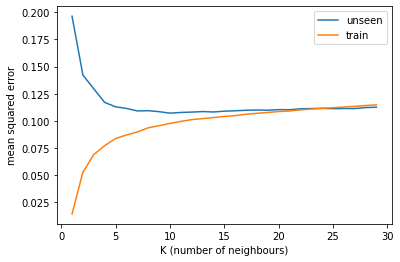

In [42]:
(num_instances, num_features) = x_25.shape
n_test, n_valid = num_instances // 5, num_instances // 5
inds = np.random.permutation(num_instances)

#rest for training and validation
n_rest = num_instances - n_test

#define a function for the MSE loss
loss = lambda y, yh: np.mean((y-yh)**2)

#Plot the mean square error for different K values stored in K_list
K_list = range(1,30)
err_train, err_test = [], []
for i, K in enumerate(K_list):
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_train_25, y_train_25)
    err_test.append(loss(model.predict(x_test_25), y_test_25))
    err_train.append(loss(model.predict(x_train_25), y_train_25))

plt.plot(K_list, err_test, '-', label='unseen')
plt.plot(K_list, err_train, '-', label='train')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

The plot above hints us that the desired K will be around 5 to 10.

### Validation set

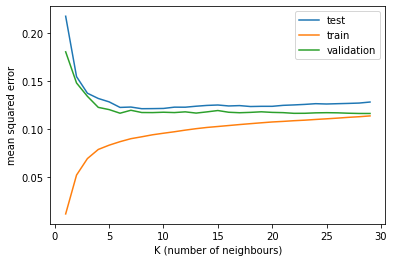

In [48]:
#Split into train, validation and test (8:1:1)
n_test, n_valid = num_instances // 10, num_instances // 10
inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_valid, y_valid = x[inds[n_test:n_test+n_valid]], y[inds[n_test:n_test+n_valid]]
x_train, y_train = x[inds[n_test+n_valid:]], y[inds[n_test+n_valid:]]

#Plot the mean square error for different K values stored in K_list
K_list = range(1,30)
err_train, err_test, err_valid = [], [], []
for i, K in enumerate(K_list):
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_train, y_train)
    err_test.append(loss(model.predict(x_test), y_test))
    err_valid.append(loss(model.predict(x_valid), y_valid))
    err_train.append(loss(model.predict(x_train), y_train))
    
plt.plot(K_list, err_test,  label='test')
plt.plot(K_list, err_train,  label='train')
plt.plot(K_list, err_valid, label='validation')

plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

### Cross Validation

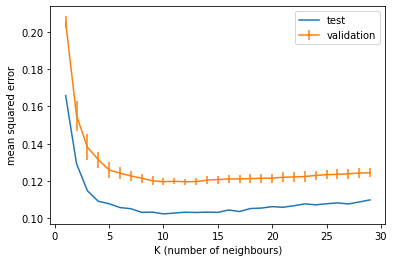

In [47]:
# Split data
inds = np.random.permutation(num_instances)
x_test, y_test = x[inds[:n_test]], y[inds[:n_test]]
x_rest, y_rest = x[inds[n_test:]], y[inds[n_test:]]
n_rest = num_instances - n_test # Store number of remaining data for train and valid

num_folds = 5
err_test, err_valid = np.zeros(len(K_list)), np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        model = model.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = loss(y_rest[val], model.predict(x_rest[val]))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_rest, y_rest)
    err_test[i]= loss(y_test, model.predict(x_test))
    
plt.plot(K_list, err_test,  label='test')
plt.errorbar(K_list, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

## Confusion matrix

In [51]:
from sklearn import tree, model_selection
x, y = datasets.load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)
yh_test = tree.DecisionTreeClassifier().fit(x_train, y_train).predict(x_test)

def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    return c_matrix

cmat = confusion_matrix(y_test, yh_test)
print(cmat)
print(f'accuracy: {np.sum(np.diag(cmat))/np.sum(cmat)}')

[[ 9.  0.  0.]
 [ 0. 12.  0.]
 [ 0.  0.  9.]]
accuracy: 1.0


----------------------------------------------- Poubelle --------->

## Task 1 : Implement and perform 5-fold cross validation on the training/validation data

In [15]:
# Test with k =1
# Note: This code is inspired from the sklearn tutorial

n_neighbors = 1
knn_model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors) # Initialize model
knn_model.fit(x_train, y_train)

# Predict
y_pred = knn_model.predict(x_train)
acc = np.mean(y_pred == y_train)

print(f'{acc:.4f}') # Should be 100%

0.9712


In [16]:
# Cross validation implementation

from sklearn.model_selection import cross_val_score
knn_model = neighbors.KNeighborsClassifier(n_neighbors=1)
scores    = cross_val_score(knn_model, x_train, y_train, cv=30)

print(f'averaged {scores.mean():.3f} ± {scores.std():.3f} over {scores.shape[0]} trials')

averaged 0.818 ± 0.010 over 30 trials


In [ ]:
# Cross validation on 25% of data

In [ ]:
# Cross validation on 50% of data

In [ ]:
# Cross validation on 75% of data

In [ ]:
# Cross validation on 100% of data

In [18]:
best_acc = 0
for data, tag in zip((x_train, x_normalized_train), ('unnormalized', 'normalized')):

  for n_neighbors in np.arange(1,20):

    knn_model = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    acc = cross_val_score(knn_model, data, y_train, cv=10).mean()

    if acc > best_acc:
      best_cfg = (tag, n_neighbors)
      best_acc = acc
      best_model = knn_model

print(f'best cross validation accuracy : {best_acc:.3f} found with config {best_cfg}')

best cross validation accuracy : 0.850 found with config ('unnormalized', 18)


## Decision Tree